# Detección de Outliers

Los datos que usaremos en este notebook corresponden a un problema de pronóstico con ventas. En esta ocasión lo que realizaremos, será un exploración a la libreria pyod para la detección de outliers.


### 1. Importar Librerías y módulos

In [3]:
import pandas as pd
import numpy as np
# Importa modelos
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline 

### 2. Leyendo y describiendo los datos

In [31]:
df = pd.read_csv("trainExploration.csv")

In [32]:
df.head(8)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636


In [6]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


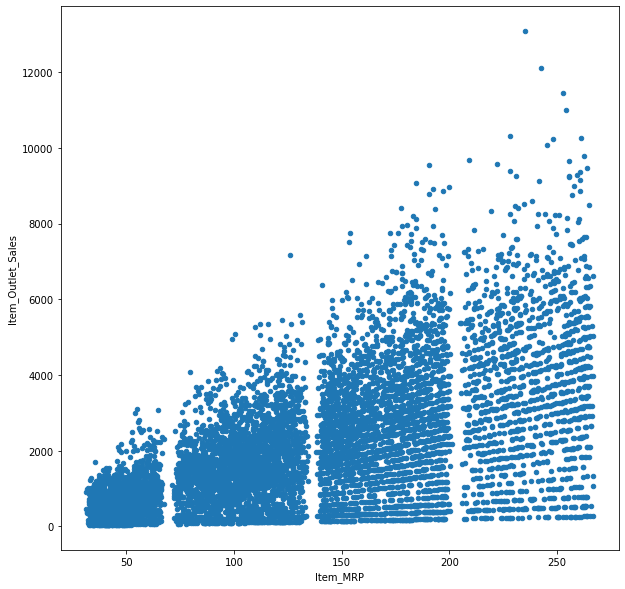

In [7]:
df.plot.scatter('Item_MRP','Item_Outlet_Sales',figsize=(10, 10))

El rango de ventas de salida de artículos es de 0 a 12000 y el MRP de artículos es de 0 a 250. Escalaremos ambas funciones a un rango entre 0 y 1. Esto es necesario para crear una visualización explicable (se hará demasiado estirado) de otra manera). En cuanto a estos datos, usar el mismo enfoque tomará mucho más tiempo para crear la visualización.

**Nota: Si no desea la visualización, puede usar la misma escala para predecir si un punto es atípico o no.**

### 3) Escalemos Datos

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


Nuevamente, crearemos un diccionario. Pero esta vez, agregaremos algunos modelos más y veremos cómo cada modelo predice valores atípicos.

Puede establecer el valor de la fracción atípica según su problema y su comprensión de los datos. En nuestro ejemplo, quiero detectar un 5% de observaciones que no son similares al resto de los datos. Por lo tanto, voy a establecer el valor de la fracción atípica como 0.05.



In [9]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05

### 4) Ahora, ajustaremos los datos a cada modelo uno por uno y veremos cuán diferente cada modelo predice los valores atípicos.

In [10]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

In [29]:
def mostrar_modelo(X, clf,clf_name,x_grid,y_grid, variable):
    clf.fit(X)
    # Predice un puntaje bruto (inicial) de anomalía
    scores_pred = clf.decision_function(X) * -1
        
    # Predicción de la categoria de un punto en outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # Copia del dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - característica inlier 1,  IX2 - característica feature 2
    IX1 =  np.array(dfx[variable][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx[variable][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # Valor de umbral a tener en cuenta para considerar un punto como outlier o inlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # Función de decisión que calula el puntaje bruto de anomalía para cada punto
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # Mapeo azul para para el degradado desde el minimo puntaje de anomalía hasta el valor de umbral
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # Dibuja un contorno rojo donde el puntaje de anomalía es igual al umbral
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # Rellena en naranja lineas de contorno donde el rango del puntaje de la anomalía es desde el umbral al máximo puntaje de anomalía
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 se utilizapara dejarlo en la esquina superior izquierda
    plt.legend(
        [a.collections[0], b,c],
        ['Función de decisión aprendida', 'inliers','outliers'],
        #prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()
    return dfx

Almacene estos valores en la matriz NumPy para usarlos en nuestros modelos más adelante:

In [27]:
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

### Angle-based Outlier Detector (ABOD)

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


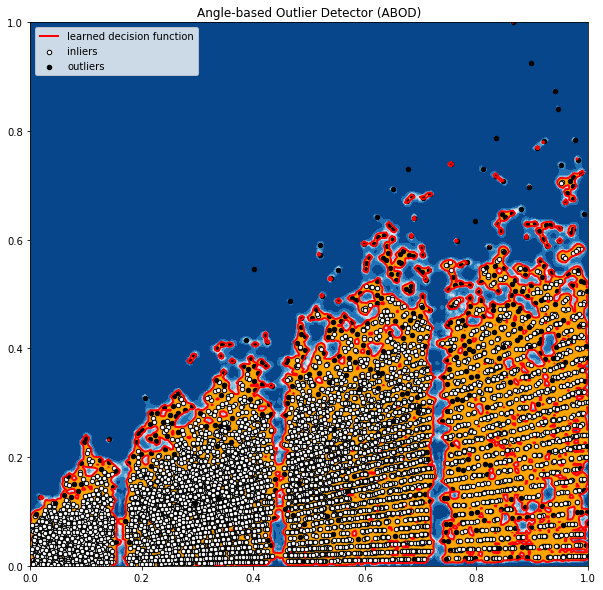

In [30]:
y_pred = mostrar_modelo(X,ABOD(contamination=outliers_fraction),'Angle-based Outlier Detector (ABOD)',xx,yy,'Item_MRP')

* Considera la relación entre cada punto y sus vecinos. 
* No considera las relaciones entre estos vecinos. 
* ABOD funciona bien en datos multidimensionales
* PyOD proporciona dos versiones diferentes de ABOD:
  * ABOD rápido (Fast ABOD): utiliza k-vecinos más cercanos para aproximarse
  * ABOD original (Original ABOD): considera todos los puntos de entrenamiento con alta complejidad

In [25]:
y_pred.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,outlier
0,FDA15,9.30,Low Fat,0.016047,Dairy,0.927507,OUT049,1999,Medium,Tier 1,Supermarket Type1,0.283587,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,0.072068,OUT018,2009,Medium,Tier 3,Supermarket Type2,0.031419,0
2,FDN15,17.50,Low Fat,0.016760,Meat,0.468288,OUT049,1999,Medium,Tier 1,Supermarket Type1,0.158115,0
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,0.640093,OUT010,1998,NaN,Tier 3,Grocery Store,0.053555,0
4,NCD19,8.93,Low Fat,0.000000,Household,0.095805,OUT013,1987,High,Tier 3,Supermarket Type1,0.073651,0


### Cluster-based Local Outlier Factor (CBLOF)

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


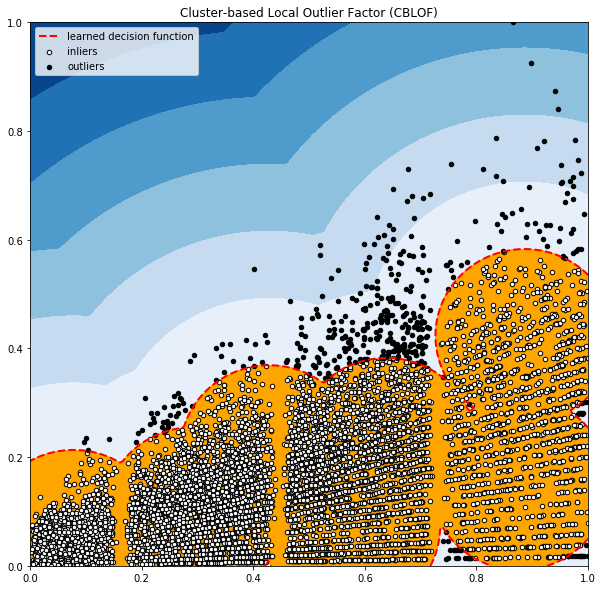

In [32]:
mostrar_modelo(CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),'Cluster-based Local Outlier Factor (CBLOF)',xx,yy,'Item_MRP')

* Clasifica los datos en pequeños grupos y grandes grupos. El puntaje de anomalía se calcula en función del tamaño del grupo al que pertenece el punto, así como la distancia al grupo grande más cercano

### Feature Bagging

OUTLIERS :  381 INLIERS :  8142 Feature Bagging


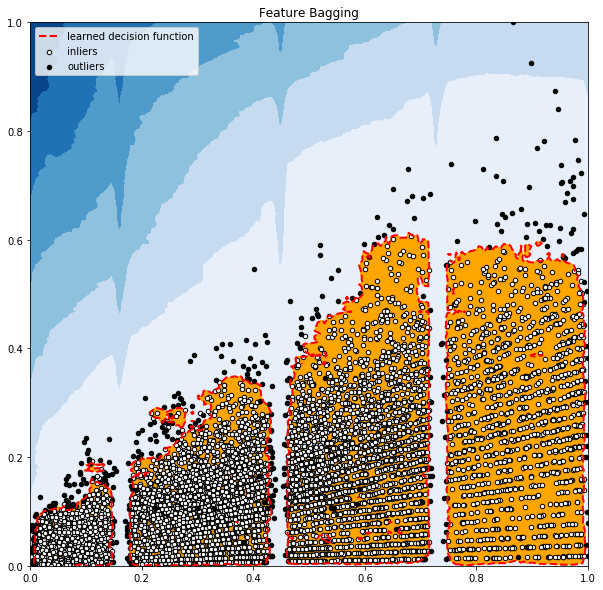

In [33]:
mostrar_modelo(X,FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),'Feature Bagging',xx,yy,'Item_MRP')

* Un detector de embolsado (bagging) de funciones se adapta a varios detectores de base en varias submuestras del conjunto de datos. Utiliza el promedio u otros métodos combinados para mejorar la precisión de la predicción.
* Por defecto, el factor de valor atípico local (LOF) se utiliza como el estimador base. Sin embargo, cualquier estimador podría usarse como el estimador base, como kNN y ABOD
* El conjunto embolsado (bagging) de características primero construye n submuestras seleccionando aleatoriamente un subconjunto de características. Esto pone de manifiesto la diversidad de estimadores básicos. Finalmente, el puntaje de predicción se genera promediando o tomando el máximo de todos los detectores base



### Histogram-base Outlier Detection (HBOS)

OUTLIERS :  501 INLIERS :  8022 Histogram-base Outlier Detection (HBOS)


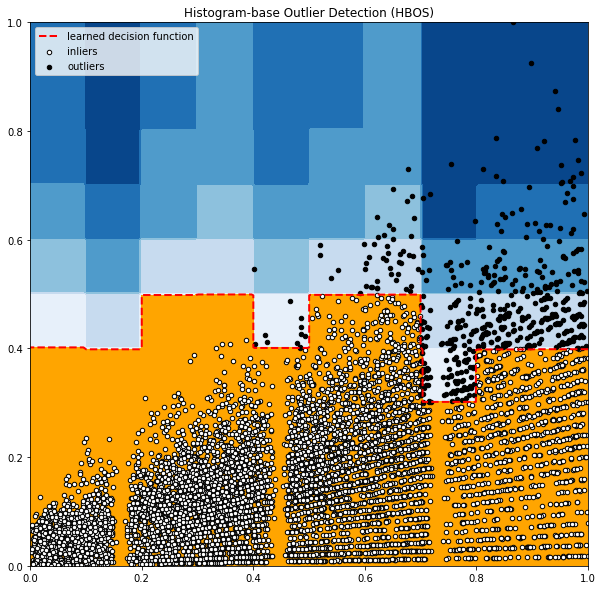

In [34]:
mostrar_modelo(X,HBOS(contamination=outliers_fraction),'Histogram-base Outlier Detection (HBOS)',xx,yy,'Item_MRP')

* Es un método eficiente sin supervisión que asume la independencia de la característica y calcula la puntuación atípica mediante la construcción de histogramas.
* Es mucho más rápido que los enfoques multivariados, pero a costa de una menor precisión.

### Isolation Forest

/home/innovacion/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


OUTLIERS :  427 INLIERS :  8096 Isolation Forest


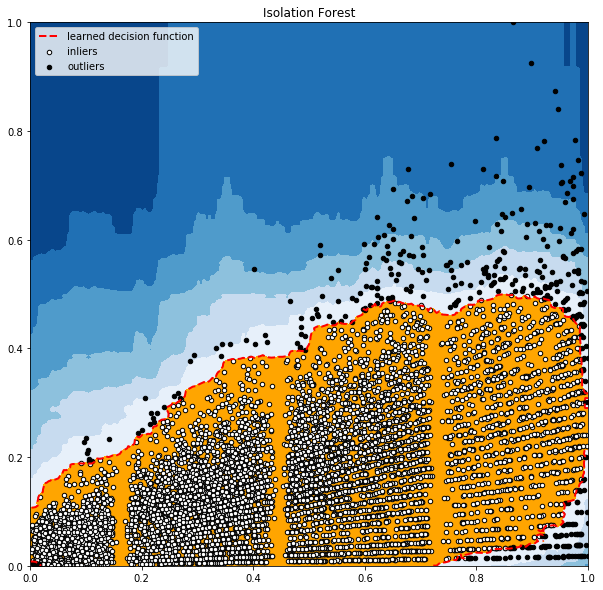

In [35]:
mostrar_modelo(X,IForest(contamination=outliers_fraction,random_state=random_state),'Isolation Forest',xx,yy,'Item_MRP')

* Utiliza la biblioteca scikit-learn internamente. En este método, la partición de datos se realiza mediante un conjunto de árboles. El bosque de aislamiento proporciona una puntuación de anomalía que observa cuán aislado está el punto en la estructura. El puntaje de anomalía se usa para identificar valores atípicos de observaciones normales
* Isolation Forest funciona bien en datos multidimensionales

### K Nearest Neighbors (KNN)

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


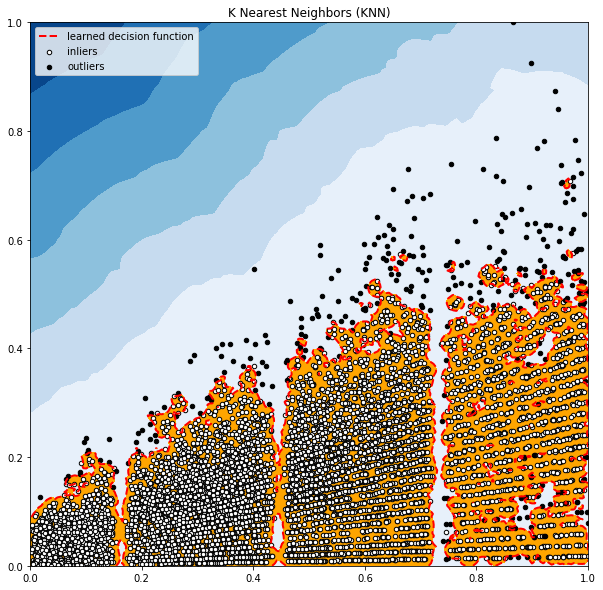

In [36]:
mostrar_modelo(X,KNN(contamination=outliers_fraction),'K Nearest Neighbors (KNN)',xx,yy,'Item_MRP')

* Para cualquier punto de datos, la distancia a su késimo vecino más cercano podría verse como la puntuación periférica
* PyOD admite tres detectores kNN:
  * Mayor (Largest): utiliza la distancia del késimo vecino como puntaje atípico
  * Media (mean): utiliza el promedio de todos los k vecinos como puntaje atípico
  * Mediana (mean): utiliza la mediana de la distancia a k vecinos como puntaje atípico


### Average KNN

OUTLIERS :  176 INLIERS :  8347 Average KNN


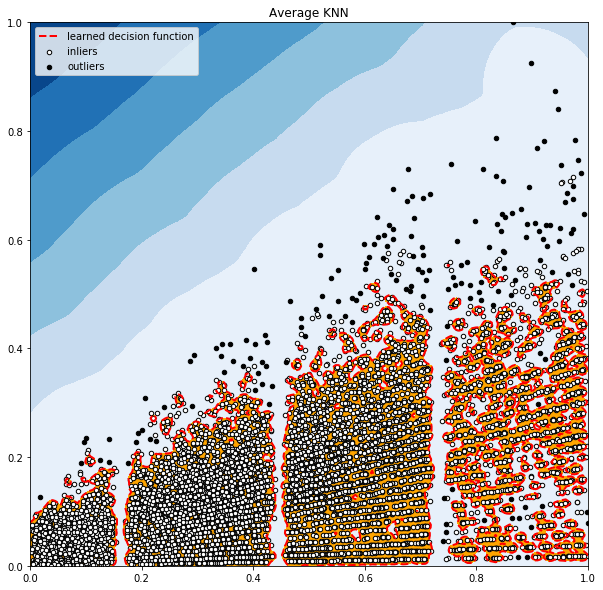

In [40]:
mostrar_modelo(X,KNN(method='mean',contamination=outliers_fraction),'Average KNN',xx,yy,'Item_MRP')